In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from scipy import stats

#for decision tree visualization
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

# Decision Trees

A **decision tree** over  $\mathbb{R}^p$ is a binary tree $T$ where each node is assigned a condition, which is a boolean valued function on $\mathbb{R}^p$, and a value. Let us create and visualize a decision tree over $\mathbb{R}^2$.

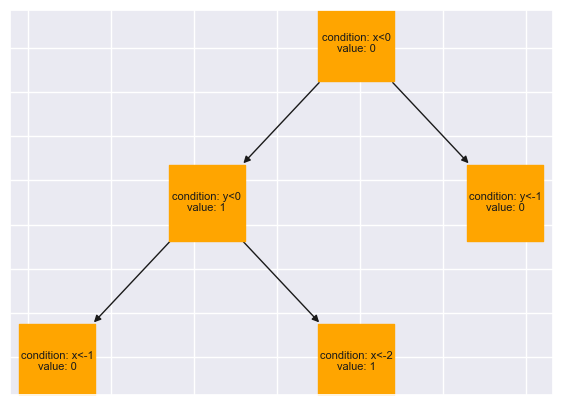

In [2]:
T=nx.DiGraph()
nodes = [
    ('0', {'condition':'x<0', 'value':0}),
    ('1', {'condition':'y<0', 'value':1}),
    ('2', {'condition':'y<-1', 'value':0}),
    ('3', {'condition':'x<-1', 'value':0}),
    ('4', {'condition':'x<-2', 'value':1}),
]
edges = [['0','1'],['0','2'],['1','3'],['1','4']]
T.add_nodes_from(nodes)
T.add_edges_from(edges)

label_dict = {}
for node in T:
    info=T.nodes[node]
    label_dict[node]="condition: {0}\nvalue: {1}".format(
        info['condition'],info['value']
    )
pos = graphviz_layout(T, prog="dot")
fig = plt.figure(figsize=(7,5))
nx.draw_networkx(T, pos, node_shape='s',node_size=3000, font_size=8, node_color='orange',labels=label_dict, with_labels=True)
plt.show()

For every decision tree $T$, we can assign a function $f_T$ on $\mathbb{R}^p$ as follows:

**def** $f_T(x)$:\
&nbsp;&nbsp; currentNode = the root of T\
&nbsp;&nbsp; **while** currentNode is not a leaf:\
&nbsp;&nbsp;&nbsp;&nbsp; **if** x satisfies the condition of currentNode:\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; currentNode = the left child of the currentNode\
&nbsp;&nbsp;&nbsp;&nbsp; **else**:\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; currentNode = the right child of the currentNode\
&nbsp;&nbsp; **return** the value of the currentNode

In this function, $f_T$ takes an input vector $x$ and navigates through the decision tree $T$ until it reaches a leaf node. At each non-leaf node, the algorithm assesses the condition, proceeding to the left child if $x$ satisfies the condition, and to the right child otherwise. This iterative process persists until a leaf node is encountered, at which point the function returns the value assigned to that specific leaf node.

For the specific decision tree described above, we get
$$f_T(x,y) = \begin{cases}
0, & x<0, y<0 \\
1, & x<0, y\geq0 \\
0, & x \geq 0
\end{cases} 
$$

The values assigned to internal nodes and the conditions specified for leaf nodes are not employed when assigning a function to a decision tree. However, these values and conditions become valuable when we aim to prune or expand a decision tree.

# Decision Tree Classifier

## Algorithm

Given a classification dataset $(X,y)$ with $p$ features, a decision tree classifier over $\mathbb{R}^p$ is constructed with values in the set of classes. The induced function from the tree is then utilized for predicting the classes. Let's delve into the process of learning a decision tree from data.


**def** makeDecisionTree(X,y):\
&nbsp;&nbsp; root = DecisionTreeNode()\
&nbsp;&nbsp; root.value = y.mode()\
&nbsp;&nbsp; root.condition = $x_i < r$ for some feature $x_i$ and a splitting value $r$\
&nbsp;&nbsp; **if** root satisfies the stopping condition:\
&nbsp;&nbsp;&nbsp;&nbsp; **return** root\
&nbsp;&nbsp; $(X_L,y_L)$ = data points with $x_i<r$\
&nbsp;&nbsp; $(X_R,y_R)$ = data points with $x_i\geq r$\
&nbsp;&nbsp; root.left = makeDecisionTree($X_L,y_L$)\
&nbsp;&nbsp; root.right = makeDecisionTree($X_R,y_R$)\
&nbsp;&nbsp; **return** root

In this implementation, the function makeDecisionTree takes the input data $X$ and corresponding labels $y$ to create a decision tree. It begins by initializing a root node with a value representing the mode of the labels y. The condition for splitting the data is based on a feature $x_i$ and a threshold $r$. We will consider how to choose $x_i$ and $r$ later.

The algorithm then checks if the root node satisfies a stopping condition, and if so, it returns the current root. Otherwise, it divides the data into two subsets, $(X_L,y_L)$ and $(X_R,y_R)$, based on the specified condition. Recursive calls to makeDecisionTree are made for the left and right subtrees with the respective subsets of data.

This process continues until the stopping condition is met, resulting in the construction of a decision tree that can be used for classification. Stopping condition can be $y$ being a constant (or almost constant) array, number of data points being under a certain threshold, or the node reaching a certain depth in the tree.

## Splitting criteria

Let's explore the process of selecting the feature and splitting value that determine the condition of a node in the decision tree. The optimal split is one that divides the dataset into two parts, each containing points from a single class. However, achieving such purity is seldom possible, particularly with a straightforward condition like $x_i < r$. Therefore, our goal is to have separated parts that are as homogeneous as possible while maintaining sufficient size.

The degree of homogeneity can be quantified as follows. For a collection of objects $C$, homogeneity is defined as the probability of two independent samples with replacement from $C$ having the same class. We denote this quantity by $hom(C)$. (Note: hom(C)=1 - [gini_impurity(C)](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity)).

If there are $m$ classes, and $p_i$ denotes the probability of a random sample having the $i_{th}$ class, then homogeneity is computed as:
$$hom(C) = \sum_{i=1}^m p_i^2.$$

Homogeneity achieves the maximum value of $1$ when all objects are from the same class and the minimum value of $\frac{1}{m}$ when all classes are uniformly distributed.

Now, let's assume we split $C$ into two parts, $A$ and $B$. Let $p_A$ and $p_B$ denote the probability of a random sample being from $A$ and $B$ respectively. We define the homogeneity **gain** from this partition as follows:
$$gain = p_A \cdot hom(A) + p_B \cdot hom(B) - hom(C).$$
Let $p_{i,A}$ (resp. $p_{i,B}$) denote the probablity of a random sample from $C$ being from $A$ (resp. $B$) and having the $i_{th}$ class. Then,
$$gain = \bigg(\sum_{i=1}^m \frac{p_{i,A}^2}{p_A} + \frac{p_{i,B}^2}{p_B} \bigg) - hom(C)$$

Returning to the algorithm, we choose the feature $x_i$ and splitting threshold $r$ that maximize the homogeneity gain. This raises the question of how to determine the optimal threshold for a given feature $x_i$.

## Choosing the splitting threshold

To determine the optimal threshold for feature $x_i$, we can explore all values $x_i$ takes over the dataset. Let us see that it is enough to consider $x_i$'s where a class change occurs. Assume that $C$ can be partitioned into $A,B,X$, where all objects in $X$ have class $1$. Let us show that among all partitions $X_0,X_1$ of $X$, maximum gain of the partition $(A \cup X_0, B \cup X_1)$ is achieved when $X_0$ or $X_1$ is empty.

Let $t$ and $c$ denote the probability of an object being from $X_0$ and $X$ respectively. Then, the gain of the partition $(A \cup X_0, B \cup X_1)$  becomes:
$$\frac{(p_{1,A}+t)^2}{p_A+t} + \sum_{i=2}^m \frac{p_{i,A}^2}{p_A+t}+\frac{(p_{1,B}+c-t)^2}{p_B+c-t} + \sum_{i=2}^m \frac{p_{i,B}^2}{p_B+c-t} - hom(C)$$
Each summand of this expression is a convex function of $t$ over $[0,c]$, which implies that the whole expression is a convex function of $t$. Hence, it achieves its maximum at the endpoints $t=0$ or $t=c$, which is realized when $X_0$ or $X_1$ is empty.

## Feature importance

A feature can be deemed important if it is frequently utilized for splitting a substantial amount of data and with high homogeneity gains. 
To express this more precisely, let's refine the statement:

Given a decision tree node $N$, we introduce the following metrics:

- Let $feature(N)$ denote the feature used for splitting at node $N$.
- Let $weight(N)$ denote the total weight of the data points associated with the node.
- Let $gain(N)$ denote the homogeneity gain at the given node.
- Let $W$ denote the total weight of the whole data set.

Now, we can define the importance of the feature $x_i$ as follows:
$$importance(x_i) := \sum_{N,feature(N)=x_i} \frac{weight(N)}{W}gain(N). $$

# Decision Tree Regressor

Decision tree regression closely resembles decision tree classification, differing in the criteria for splitting and the value assigned to nodes. In decision tree regression, the splitting criterion involves maximizing the variance loss rather than maximizing the gain in homogeneity. Additionally, the value assigned to each leaf node is determined by the mean, in contrast to the mode used in classification.

# Random Forests

Decision trees with sufficient height often exhibit low training bias but tend to suffer from high variance, indicating that minor variations in the training data can lead to significant changes in the resultant model. Consequently, this may result in suboptimal prediction performance on unseen data. The Random Forest algorithm addresses this challenge. In the construction of a Random Forest, numerous decision trees are built using random samples and random features, and their responses are averaged during prediction. This ensemble approach helps mitigate the high variance associated with individual decision trees, enhancing the model's robustness and generalization capability. We provide a more precise description of fitting data to a Random Forest estimator with the following algorithm:

**for** k=1,...,N:\
&nbsp;&nbsp; Sample $n$ random instances from the dataset with replacement.\
&nbsp;&nbsp; Train a decision tree $T_k$ on the sample. During the training, at each split, use $m$ random feautures instead of the whole set of features.

The predicted value assigned to an object with features $x$ is determined by $mode(T_k(x): k=1,\dots,N)$ for classification, and $mean(T_k(x): k=1,\dots,N)$ for regression.

# Implementing Decision Trees and Random Forests

Initially, we create several utility functions. While some of their inputs or outputs may appear redundant, their inclusion is intentional to prevent the unnecessary recalculation of identical quantities and to facilitate recursive utilization.

In [3]:
def classWeights(y,weights):
    class_weights = {}
    for c, weight in zip(y,weights):
        class_weights[c]=class_weights.get(c,0)+weight
    return class_weights
def filterIndices(X,feature,split,sorted_indices):
    n, p = X.shape
    left_indices=[None]*p
    right_indices=[None]*p
    for i, I in enumerate(sorted_indices):
        left_indices[i] = [j for j in I if X[j,feature]<split]
        right_indices[i] = [j for j in I if X[j,feature]>=split]
    return left_indices, right_indices
def homogeneity(class_weights, total_weight):
    return sum([w**2 for w in class_weights.values()])/total_weight**2
def homogeneityGain(left_hom, left_total, right_hom, right_total, total_weight, hom):
    return (left_total/total_weight)*left_hom + (right_total/total_weight)*right_hom - hom
def mean(weighted_sum, total_weight):
    return weighted_sum/total_weight
def mode(class_weights):
    max_weight = -float('inf')
    result = None
    for c, weight in class_weights.items():
        if weight>max_weight:
            result = c
            max_weight = weight
    return result
def sortIndices(X):
    n, p = X.shape
    sorted_indices = [None]*p
    for feature in range(p):
        sorted_indices[feature]=sorted(range(n), key = lambda i: X[i,feature])
    return sorted_indices
def totalWeight(weights):
    return weights.sum()
def variance(weighted_sum_of_squares, weighted_sum, total_weight):
    return (weighted_sum_of_squares/total_weight)-(weighted_sum/total_weight)**2
def varianceLoss(left_var, left_total, right_var, right_total, total_weight, var):
    return var - (left_total/total_weight)*left_var - (right_total/total_weight)*right_var
def weightedSum(y, weights):
    return y @ weights
def weightedSumOfSquares(y,weights):
    return y**2 @ weights

Now, let us implement the functions finding the best split.

In [4]:
def bestClassificationSplit(X,y,weights,sorted_indices,class_weights,total_weight,hom,
                            density=1, num_features='max'):
    max_gain = -float('inf')
    best_feature = None
    best_split = None
    best_left_weights = None
    best_right_weights = None
    best_left_total = None
    best_right_total = None
    best_left_hom = None
    best_right_hom = None
    best_left_density = None
    best_right_density = None
    features = np.arange(X.shape[1])
    if num_features != 'max':
        features = np.random.choice(features, num_features, replace=False)
    for feature in features:
        left_weights = {}
        left_total = 0
        right_weights = class_weights.copy()
        right_total = total_weight
        I=sorted_indices[feature]
        for i in range(len(I)-1):
            i1, i2 = I[i], I[i+1]
            c = y[i1]
            w = weights[i1]
            left_weights[c]=left_weights.get(c,0)+w
            left_total += w
            right_weights[c]-=w
            right_total -= w
            if y[i1]==y[i2] or X[i1,feature]==X[i2,feature]:
                continue
            left_hom = homogeneity(left_weights,left_total)
            right_hom = homogeneity(right_weights,right_total)
            gain = homogeneityGain(left_hom, left_total, right_hom, right_total, 
                                   total_weight, hom)
            if gain>max_gain:
                max_gain = gain
                best_feature = feature
                best_split = (X[i1,feature]+X[i2,feature])/2
                best_left_weights = left_weights.copy()
                best_right_weights = right_weights.copy()
                best_left_total = left_total
                best_right_total = right_total
                best_left_hom = left_hom
                best_right_hom = right_hom
                best_left_density = (left_total/total_weight)*density
                best_right_density = (right_total/total_weight)*density
    left_indices, right_indices = filterIndices(X,best_feature,
                                                best_split,sorted_indices)
    left_data = (left_indices, best_left_weights, best_left_total, 
                 best_left_hom, best_left_density)
    right_data = (right_indices, best_right_weights, best_right_total, 
                  best_right_hom, best_right_density)
    return best_feature, best_split, max_gain, left_data, right_data

def bestRegressionSplit(X,y,weights,sorted_indices,weighted_sum_of_squares,weighted_sum,
                        total_weight,var,density=1,num_features='max'):
    max_loss = -float('inf')
    best_feature = None
    best_split = None
    best_left_weights = None
    best_right_weights = None
    best_left_total = None
    best_right_total = None
    best_left_hom = None
    best_right_hom = None
    best_left_density = None
    best_right_density = None
    features = np.arange(X.shape[1])
    if num_features != 'max':
        features = np.random.choice(features, num_features, replace=False)
    for feature in features:
        left_squares = 0
        left_sum = 0
        left_total = 0
        right_squares = weighted_sum_of_squares
        right_sum = weighted_sum
        right_total = total_weight
        I=sorted_indices[feature]
        for i in range(len(I)-1):
            i1, i2 = I[i], I[i+1]
            val = y[i1]
            w = weights[i1]
            left_squares += w*(val**2)
            left_sum += w*val
            left_total += w
            right_squares -= w*(val**2)
            right_sum -= w*val
            right_total -= w
            if X[i1,feature]==X[i2,feature]:
                continue
            left_var = variance(left_squares,left_sum,left_total)
            right_var = variance(right_squares,right_sum,right_total)
            loss = varianceLoss(left_var, left_total, right_var, right_total, 
                                total_weight, var)
            if loss>max_loss:
                max_loss = loss
                best_feature = feature
                best_split = (X[i1,feature]+X[i2,feature])/2
                best_left_squares = left_squares
                best_right_squares = right_squares
                best_left_sum = left_sum
                best_right_sum = right_sum
                best_left_total = left_total
                best_right_total = right_total
                best_left_var = left_var
                best_right_var = right_var
                best_left_density = (left_total/total_weight)*density
                best_right_density = (right_total/total_weight)*density
    left_indices, right_indices = filterIndices(X,best_feature,best_split,sorted_indices)
    left_data = (left_indices, best_left_squares, best_left_sum, 
                 best_left_total, best_left_var, best_left_density)
    right_data = (right_indices, best_right_squares, best_right_sum, 
                  best_right_total, best_right_var, best_right_density)
    return best_feature, best_split, max_loss, left_data, right_data

In [5]:
#Node classes for decision trees
class ClassificationNode:
    def __init__(self):
        self.value = None
        self.feature = None
        self.split = None
        self.gain = None
        self.hom = None
        self.density = None
        self.depth = None
        self.left = None
        self.right = None

class RegressionNode:
    def __init__(self):
        self.value = None
        self.feature = None
        self.split = None
        self.loss = None
        self.var = None
        self.density = None
        self.depth = None
        self.left = None
        self.right = None

In [6]:
class DecisionTreeClassifier:
    def __init__(self,max_height=5,hom_threshold=0.99, min_leaf=1):
        self.max_height=max_height
        self.hom_threshold=hom_threshold
        self.min_leaf=min_leaf
        self.root = None
        self.dimension = None
    def fit(self,X,y,weights='uniform',num_features='max'):
        def makeDecisionTree(sorted_indices,class_weights,total_weight,hom,density=1,depth=0):
            node = ClassificationNode()
            node.value = mode(class_weights)
            node.hom = hom
            node.density = density
            node.depth = depth
            if depth>=self.max_height or hom>=self.hom_threshold or len(sorted_indices[0])<=self.min_leaf:
                return node
            feature, split, gain, left_data, right_data = bestClassificationSplit(X,y,weights,
                                                                                  sorted_indices,class_weights,
                                                                                  total_weight,hom,density,
                                                                                  num_features)
            node.feature = feature
            node.split = split
            node.gain = gain
            node.left = makeDecisionTree(*left_data,depth+1)
            node.right = makeDecisionTree(*right_data,depth+1)
            return node
        if weights=='uniform':
            weights = np.ones(len(y))
        sorted_indices = sortIndices(X)
        class_weights = classWeights(y,weights)
        total_weight = totalWeight(weights)
        hom = homogeneity(class_weights,total_weight)
        self.root = makeDecisionTree(sorted_indices, class_weights, total_weight,hom)
        self.dimension = X.shape[1]
    def predict(self,X):
        result = np.zeros(X.shape[0])
        for i, x in enumerate(X):
            current_node=self.root
            while current_node.left != None:
                if x[current_node.feature]<current_node.split:
                    current_node = current_node.left
                else:
                    current_node = current_node.right
            result[i]=current_node.value
        return result
    def featureImportance(self):
        result = np.zeros(self.dimension)
        Q=[self.root]
        while Q:
            node = Q.pop()
            if node.left != None:
                result[node.feature]+=node.gain*node.density
                Q.append(node.left)
                Q.append(node.right)
        return result
    def plot(self,ax,node_size=3000,font_size=8):
        label_dict = {}
        Q=[(self.root,"root")]
        T=nx.DiGraph()
        T.add_node('root')
        while Q:
            node, label = Q.pop()
            if node.left == None:
                info = f"Val:{node.value}\nHom:{node.hom:.2f}\nDensity:{node.density:.3f}"
            else:
                info = (f"Feature:$x_{node.feature}$\nSplit:{node.split:.2f}\nGain:{node.gain:.2f}"+
                        f"\nHom:{node.hom:.2f}\nDensity:{node.density:.3f}")
            label_dict[label]=info
            if node.left:
                left_label=label+"L"
                right_label=label+"R"
                Q.append((node.left,left_label))
                Q.append((node.right,right_label))
                T.add_node(left_label)
                T.add_node(right_label)
                T.add_edge(label,left_label)
                T.add_edge(label,right_label)
        pos = graphviz_layout(T, prog="dot")
        nx.draw_networkx(T, pos, node_shape='s',node_size=node_size, font_size=font_size, 
                         node_color='orange',labels=label_dict, with_labels=True)

In [7]:
class DecisionTreeRegressor:
    def __init__(self,max_height=5,var_threshold=0.001, min_leaf=1):
        self.max_height=max_height
        self.var_threshold=var_threshold
        self.min_leaf=min_leaf
        self.root = None
        self.dimension = None
    def fit(self,X,y,weights='uniform',num_features='max'):
        def makeDecisionTree(sorted_indices,weighted_sum_of_squares,weighted_sum,
                             total_weight,var,density=1,depth=0):
            node = RegressionNode()
            node.value = mean(weighted_sum,total_weight)
            node.var = var
            node.density = density
            node.depth = depth
            if depth>=self.max_height or var<=self.var_threshold or len(sorted_indices[0])<=self.min_leaf:
                return node
            feature, split, loss, left_data, right_data = bestRegressionSplit(X,y,weights,sorted_indices,
                                                                              weighted_sum_of_squares,
                                                                              weighted_sum,total_weight,
                                                                              var,density,num_features)
            node.feature = feature
            node.split = split
            node.loss = loss
            node.left = makeDecisionTree(*left_data,depth+1)
            node.right = makeDecisionTree(*right_data,depth+1)
            return node
        if weights=='uniform':
            weights = np.ones(len(y))
        sorted_indices = sortIndices(X)
        weighted_sum_of_squares = weightedSumOfSquares(y,weights)
        weighted_sum = weightedSum(y,weights)
        total_weight = totalWeight(weights)
        var = variance(weighted_sum_of_squares,weighted_sum,total_weight)
        self.root = makeDecisionTree(sorted_indices,weighted_sum_of_squares,weighted_sum,total_weight,var)
        self.dimension = X.shape[1]
    def predict(self,X):
        result = np.zeros(X.shape[0])
        for i, x in enumerate(X):
            current_node=self.root
            while current_node.left != None:
                if x[current_node.feature]<current_node.split:
                    current_node = current_node.left
                else:
                    current_node = current_node.right
            result[i]=current_node.value
        return result
    def featureImportance(self):
        result = np.zeros(self.dimension)
        Q=[self.root]
        while Q:
            node = Q.pop()
            if node.left != None:
                result[node.feature]+=node.loss*node.density
                Q.append(node.left)
                Q.append(node.right)
        return result
    def plot(self,ax,node_size=3000,font_size=8):
        label_dict = {}
        Q=[(self.root,"root")]
        T=nx.DiGraph()
        T.add_node('root')
        while Q:
            node, label = Q.pop()
            if node.left == None:
                info = f"Val:{node.value:.2f}\nVar:{node.var:.2f}\nDensity:{node.density:.3f}"
            else:
                info = (f"Feature:$x_{node.feature}$\nSplit:{node.split:.2f}\nLoss:{node.loss:.2f}"
                        +f"\nVar:{node.var:.2f}\nDensity:{node.density:.3f}")
            label_dict[label]=info
            if node.left:
                left_label=label+"L"
                right_label=label+"R"
                Q.append((node.left,left_label))
                Q.append((node.right,right_label))
                T.add_node(left_label)
                T.add_node(right_label)
                T.add_edge(label,left_label)
                T.add_edge(label,right_label)
        pos = graphviz_layout(T, prog="dot")
        nx.draw_networkx(T, pos, node_shape='s',node_size=node_size, font_size=font_size, 
                         node_color='orange',labels=label_dict, with_labels=True)

In [8]:
class RandomForestClassifier:
    def __init__(self,max_height=5,hom_threshold=0.99, min_leaf=1, num_features='max', 
                 num_estimators=20,random_state=None):
        self.max_height=max_height
        self.hom_threshold=hom_threshold
        self.min_leaf=min_leaf
        self.num_features=num_features
        self.num_estimators=num_estimators
        self.random_state=random_state
        self.ensemble = []
    def fit(self,X,y,weights='uniform'):
        if self.random_state != None:
            np.random.seed(self.random_state)
        if weights=='uniform':
            weights = np.ones(len(y))
        for k in range(self.num_estimators):
            T=DecisionTreeClassifier(self.max_height,self.hom_threshold,self.min_leaf)
            I = np.random.choice(range(X.shape[0]),X.shape[0])
            T.fit(X[I],y[I],weights[I],self.num_features)
            self.ensemble.append(T)
    def predict(self,X):
        y_preds = np.array([T.predict(X) for T in self.ensemble]).T
        return np.array([mode(classWeights(preds,np.ones(self.num_estimators))) for preds in y_preds])
    
class RandomForestRegressor:
    def __init__(self,max_height=5,var_threshold=0.001, min_leaf=1, num_features='max', 
                 num_estimators=20,random_state=None):
        self.max_height=max_height
        self.var_threshold=var_threshold
        self.min_leaf=min_leaf
        self.num_features=num_features
        self.num_estimators=num_estimators
        self.random_state=random_state
        self.ensemble = []
    def fit(self,X,y,weights='uniform'):
        if self.random_state != None:
            np.random.seed(self.random_state)
        if weights=='uniform':
            weights = np.ones(len(y))
        for k in range(self.num_estimators):
            T=DecisionTreeRegressor(self.max_height,self.var_threshold,self.min_leaf)
            I = np.random.choice(range(X.shape[0]),X.shape[0])
            T.fit(X[I],y[I],weights[I],self.num_features)
            self.ensemble.append(T)
    def predict(self,X):
        y_preds = np.array([T.predict(X) for T in self.ensemble]).T
        return y_preds.mean(axis=1)

## Examples

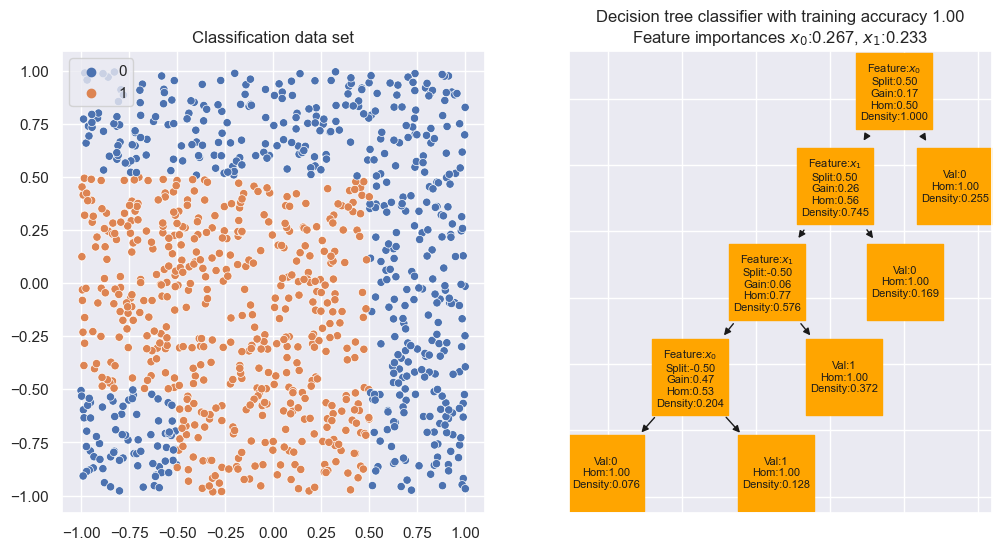

In [9]:
#create data set
N=1000
np.random.seed(13)
X=np.random.uniform(-1,1, (N,2))
y=np.array([1 if abs(x.max())<=0.5 else 0 for x in X])

#fit a decision tree
T=DecisionTreeClassifier(max_height=5)
T.fit(X,y)

#get feature importances
i0, i1 = T.featureImportance()

#calculate training accuracy
y_pred = T.predict(X)
acc = (y==y_pred).mean()

#visualize
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Classification data set')
sns.scatterplot(x=X[:,0],y=X[:,1],hue=y,ax=ax1)
ax2 = fig.add_subplot(1,2,2)
ax2.set_title(f'Decision tree classifier with training accuracy {acc:.2f}'+
              f'\nFeature importances $x_0$:{i0:.3f}, $x_1$:{i1:.3f}')
T.plot(ax2)

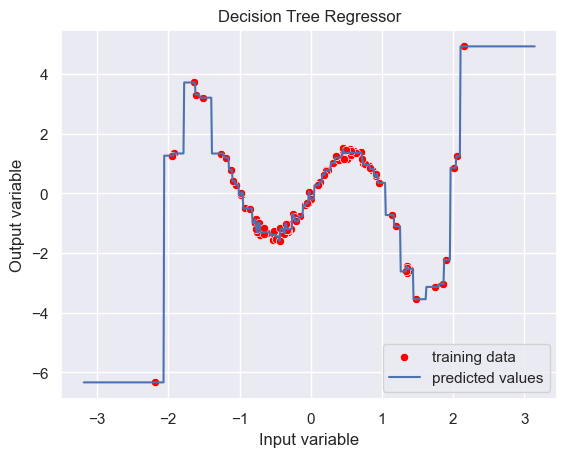

In [10]:
#create a regression data set
np.random.seed(13)
N=100
X = np.random.randn(N,1)
f = lambda x: (x+2)*(x+1)*x*(x-1)*(x-2)
y = np.array([f(x[0]) for x in X])+ 0.2*np.random.randn(N)

#fit a decision tree regressor
T=DecisionTreeRegressor(max_height=10)
T.fit(X,y)

#visualize
sns.scatterplot(x=X.reshape(N),y=y, label='training data', color='red')
xmin, xmax =X.min()-1, X.max()+1
xs = np.arange(xmin,xmax,0.01)
ys = T.predict(xs.reshape(len(xs),1))
sns.lineplot(xs,ys,label='predicted values')
plt.title('Decision Tree Regressor')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend();

# Random Forests vs Decision Trees for noisy data

The following example illustrates how random forests can effectively mitigate overfitting on noisy datasets, a challenge often encountered by individual decision trees.

In [11]:
#create a noisy classification data set

N=1250
np.random.seed(13)
X_true = np.random.uniform(-1,1,(N,9))
y = 1*(X_true[:,0]>=0)
X = X_true+0.3*np.random.randn(N,9)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

#train a decision tree classifier
dt = DecisionTreeClassifier(max_height=8)
dt.fit(X_train,y_train)
y_pred_train_dt = dt.predict(X_train)
y_pred_test_dt = dt.predict(X_test)
acc_train_dt = (y_train == y_pred_train_dt).mean()
acc_test_dt = (y_test == y_pred_test_dt).mean()

#train a random forest
rf = RandomForestClassifier(max_height=8,num_features=3,random_state=13)
rf.fit(X_train,y_train)
y_pred_train_rf = rf.predict(X_train)
y_pred_test_rf = rf.predict(X_test)
acc_train_rf = (y_train == y_pred_train_rf).mean()
acc_test_rf = (y_test == y_pred_test_rf).mean()

print(f'Decision tree training accuracy:{acc_train_dt:.2f}, test accuracy:{acc_test_dt:.2f}')
print(f'Random forest training accuracy:{acc_train_rf:.2f}, test accuracy:{acc_test_rf:.2f}')

Decision tree training accuracy:0.98, test accuracy:0.84
Random forest training accuracy:0.95, test accuracy:0.89


In [12]:
#create a noisy regression data set
N=1250
np.random.seed(13)
X_true = np.random.uniform(-1,1,(N,12))
X = X_true+0.3*np.random.randn(N,12)
y = X_true.sum(axis=1)+0.3*np.random.randn(N)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

#train a decision tree regressor
dt = DecisionTreeRegressor(max_height=10)
dt.fit(X_train,y_train)
y_pred_train_dt = dt.predict(X_train)
y_pred_test_dt = dt.predict(X_test)
mse_train_dt = ((y_train - y_pred_train_dt)**2).mean()
mse_test_dt = ((y_test- y_pred_test_dt)**2).mean()

#train a random forest
rf = RandomForestRegressor(max_height=10,num_features=4,random_state=13)
rf.fit(X_train,y_train)
y_pred_train_rf = rf.predict(X_train)
y_pred_test_rf = rf.predict(X_test)
mse_train_rf = ((y_train - y_pred_train_rf)**2).mean()
mse_test_rf = ((y_test - y_pred_test_rf)**2).mean()

print(f'Decision tree training MSE:{mse_train_dt:.2f}, test MSE:{mse_test_dt:.2f}')
print(f'Random forest training MSE:{mse_train_rf:.2f}, test MSE:{mse_test_rf:.2f}')

Decision tree training MSE:0.18, test MSE:4.34
Random forest training MSE:0.37, test MSE:1.85
